### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


### Loading the cleaned dataset

In [2]:
df = pd.read_csv('cleaned_data.csv')

### Encoding Categorical Columns

In [3]:
# One-hot encoding
from sklearn.preprocessing import LabelEncoder
df = pd.get_dummies(df, columns=['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'work_interfere',
                               'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options',
                               'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
                               'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview',
                               'phys_health_interview', 'mental_vs_physical', 'obs_consequence'], drop_first=True)

### Splitting the dataset

In [4]:
#Dropping the target column i.e., 'Age'
X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Applying log transformation to the target variable
y_train_log = np.log1p(y_train)

### Feature Selection

In [6]:
# Using a Random Forest to find the most important features
feature_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
feature_selector.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [7]:
# Getting feature importances
feature_importances = pd.DataFrame(feature_selector.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [8]:
# Selecting top 90 features
top_features = feature_importances.index[:90]

In [9]:
# Creating new datasets with only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print(f"Selected {len(top_features)} features out of {X_train.shape[1]}.")

Selected 90 features out of 90.


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Scaling the selected features
scaler = StandardScaler()
X_train_scaled_selected = scaler.fit_transform(X_train_selected)
X_test_scaled_selected = scaler.transform(X_test_selected)

# Defining parameter grids for hyperparameter tuning
param_grid_lr = {
    'fit_intercept': [True, False]
}

param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

param_grid_xgb = {
    'n_estimators': [200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0]
}

# Models for tuning
models_to_tune = {
    'Linear Regression': (LinearRegression(), param_grid_lr),
    'Random Forest Regressor': (RandomForestRegressor(random_state=42), param_grid_rf),
    'XGBoost Regressor': (XGBRegressor(random_state=42), param_grid_xgb)
}

best_models = {}

for name, (model, params) in models_to_tune.items():
    print(f"Tuning {name} with selected features and log-transformed target...")
    # Use only scaled data for Linear Regression
    if name == 'Linear Regression':
        grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_scaled_selected, y_train_log)
    else:
        grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train_selected, y_train_log)
        
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}\n")

Tuning Linear Regression with selected features and log-transformed target...
Best parameters for Linear Regression: {'fit_intercept': True}

Tuning Random Forest Regressor with selected features and log-transformed target...
Best parameters for Random Forest Regressor: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Tuning XGBoost Regressor with selected features and log-transformed target...
Best parameters for XGBoost Regressor: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}



In [11]:
for name, model in best_models.items():
    # Use scaled data for Linear Regression prediction
    if name == 'Linear Regression':
        y_pred_log = model.predict(X_test_scaled_selected)
    else:
        y_pred_log = model.predict(X_test_selected)
        
    # Inverse transform the predictions
    y_pred = np.expm1(y_pred_log)
    
    print(f"{name}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"R² Score: {r2_score(y_test, y_pred)}\n")

Linear Regression
RMSE: 6.935493462541625
MAE: 5.360526364217731
R² Score: 0.06493510815412862

Random Forest Regressor
RMSE: 6.7621966878358215
MAE: 5.224822344614846
R² Score: 0.11108012785614663

XGBoost Regressor
RMSE: 6.856870850208957
MAE: 5.3046650886535645
R² Score: 0.08601516485214233



#### Finding the best regressor

In [12]:
best_regressor = RandomForestRegressor()
best_regressor.fit(X_train, y_train)

RandomForestRegressor()

#### Plotting top features 

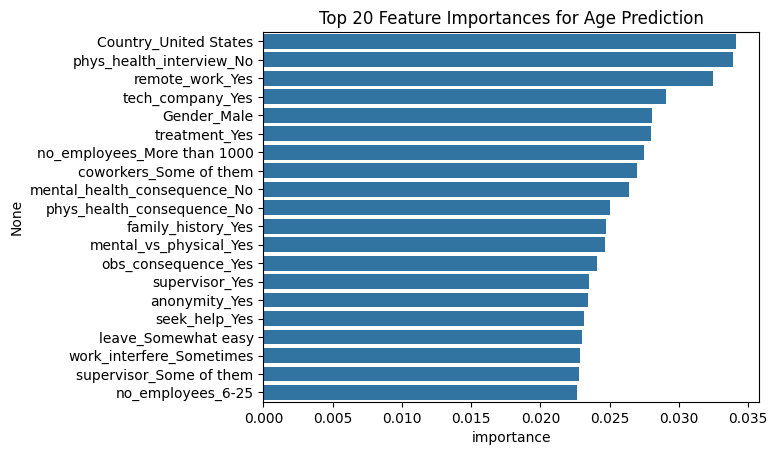

In [13]:
feature_importances = pd.DataFrame(best_regressor.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)


sns.barplot(x=feature_importances.importance[:20], y=feature_importances.index[:20])
plt.title('Top 20 Feature Importances for Age Prediction')
plt.show()